In [2]:
RUNS = 10
data_path = "models/mnist_split"

In [3]:
import skimage
from skimage import metrics

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_gradients_for_task(p, task_no, RUNS):
    data_path_p = f"models/mnist_split/{p}/"
    
    # Initialize lists to collect gradient arrays for each type
    gradients_data = []

    for run in range(RUNS):
        run_file_names_layer1 = [
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.bias.npy",
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.weight.npy"
        ]
        run_file_names_layer3 = [
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.bias.npy",
            data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.weight.npy"
        ]
        
        # Load gradient data for layer 1 and combine
        data1 = np.load(run_file_names_layer1[0])
        data2 = np.load(run_file_names_layer1[1])

        data1_biases_expanded = data1[:, np.newaxis]
        data_layer1_combined = np.hstack((data1_biases_expanded, data2))
        
        # Load gradient data for layer 3 and combine
        data3 = np.load(run_file_names_layer3[0])
        data4 = np.load(run_file_names_layer3[1])
        data3_biases_expanded = data3[:, np.newaxis]
        data_layer3_combined = np.hstack((data3_biases_expanded, data4))

        # Append the combined arrays to the list
        gradients_data.append([data_layer1_combined, data_layer3_combined])
        # gradients_data.append([data2, data4])

    return gradients_data



#gets ideal gradients for a specific task
def get_ideal_grad_for_task(task_no):
    data_path_p = f"models/mnist_split/1/train/"

    run_file_name1 = data_path_p + f"task_{task_no}/grad_layers.0.bias.npy"
    run_file_name2 = data_path_p + f"task_{task_no}/grad_layers.0.weight.npy"
    run_file_name3 = data_path_p + f"task_{task_no}/grad_output_layer.bias.npy"
    run_file_name4 = data_path_p + f"task_{task_no}/grad_output_layer.weight.npy"
        
    # data1 and data2 are the bias and weights data between layers 0 to 1
    data1 = np.load(run_file_name1)
    data2 = np.load(run_file_name2)
    data1_biases_expanded = data1[:, np.newaxis]
    data_layer1_combined = np.hstack((data1_biases_expanded, data2))

    # data3 and data4 are the bias and weights data between layers 1 and output
    data3 = np.load(run_file_name3)
    data4 = np.load(run_file_name4)
    data3_biases_expanded = data3[:, np.newaxis]
    data_layer3_combined = np.hstack((data3_biases_expanded, data4))

    return data_layer1_combined, data_layer3_combined
    # ideal_grads_data = []
    # ideal_grads_data.append([data2, data4])

    # return data2, data4

In [5]:
#calculates the different metrics for two unflattened matrices. 
def calculate_metrics(actual, ideal):
    # Ensure both arrays have the same shape
    if actual.shape != ideal.shape:
        raise ValueError(f"Shape mismatch: {actual.shape} vs {ideal.shape}")

    # removing the last column so we can reshape into a square for SSIM
    last_column_actual = actual[:, -1]  # This slices out the last column, resulting in a shape of (100,)
    actual_wo_last_column = actual[:, :-1]

    last_column_ideal = ideal[:, -1]  # This slices out the last column, resulting in a shape of (100,)
    ideal_wo_last_column = ideal[:, :-1]

    
    metrics = {}
    actual_flat = actual.flatten()
    ideal_flat = ideal.flatten()

    sqrt_size = int(actual.shape[1] ** 0.5)
    first_layer_size = actual.shape[0]

    actual_wo_last_column = actual_wo_last_column.reshape(first_layer_size, sqrt_size, sqrt_size)
    ideal_wo_last_column = ideal_wo_last_column.reshape(first_layer_size, sqrt_size, sqrt_size)

    # adding the bias term to the tensor for SSIM
    actual_bias_reshaped = last_column_actual.reshape(first_layer_size, 1, 1)
    ideal_bias_reshaped = last_column_ideal.reshape(first_layer_size, 1, 1)

    actual_bias_reshaped = np.repeat(actual_bias_reshaped, sqrt_size, axis=1)  # Now of shape (10, 28, 1)
    actual_weights_with_bias = np.concatenate((actual_wo_last_column, actual_bias_reshaped), axis=2)  # Now of shape (10, 28, 29)

    ideal_bias_reshaped = np.repeat(ideal_bias_reshaped, sqrt_size, axis=1)  # Now of shape (10, 28, 1)
    ideal_weights_with_bias = np.concatenate((ideal_wo_last_column, ideal_bias_reshaped), axis=2)  # Now of shape (10, 28, 29)

    # MSE
    metrics['MSE'] = np.mean((actual_flat - ideal_flat) ** 2)
    
    # Cosine Similarity
    dot_product = np.dot(actual_flat, ideal_flat)
    norm_actual = np.linalg.norm(actual_flat)
    norm_ideal = np.linalg.norm(ideal_flat)
    metrics['Cosine Similarity'] = dot_product / (norm_actual * norm_ideal) if (norm_actual * norm_ideal) != 0 else 0

    # peak signal to noise ratio
    metrics['PSNR'] = skimage.metrics.peak_signal_noise_ratio(actual, ideal)

    # Structural Similarity Index (SSIM)
    # need to specify data_range for this method
    combined = np.concatenate((actual_flat, ideal_flat))
    data_range = np.max(combined) - np.min(combined)

    print(f"structural weights with bias term shape: {actual_weights_with_bias.shape}")
    metrics['SSIM'] = skimage.metrics.structural_similarity(actual_weights_with_bias, ideal_weights_with_bias, data_range=data_range)
    
    return metrics

In [6]:
# additional functions
def compute_differences_and_average_with_std(gradients_runs, ideal_gradients):
    # This structure will hold metrics for each run, allowing calculation of std deviation
    run_metrics_list = []

    for run_gradients in gradients_runs:
        run_metrics = []
        for actual, ideal in zip(run_gradients, ideal_gradients):
            if actual.shape == ideal.shape:
                metrics = calculate_metrics(actual, ideal)
                run_metrics.append(metrics)
        run_metrics_list.append(run_metrics)
    
    # Calculate the average and standard deviation across runs
    averaged_metrics = []
    std_dev_metrics = []
    for layer_index in range(len(ideal_gradients)):
        layer_metrics = [run[layer_index] for run in run_metrics_list if len(run) > layer_index]
        averaged_layer_metrics = {metric: np.mean([lm[metric] for lm in layer_metrics]) for metric in layer_metrics[0]}
        std_dev_layer_metrics = {metric: np.std([lm[metric] for lm in layer_metrics], ddof=1) for metric in layer_metrics[0]}
        averaged_metrics.append(averaged_layer_metrics)
        std_dev_metrics.append(std_dev_layer_metrics)
    
    return averaged_metrics, std_dev_metrics

def compute_differences_and_average_concatenated_with_std(gradients_runs, ideal_gradients):
    concatenated_ideal = flatten_and_concatenate_gradients(ideal_gradients)
    run_metrics = []

    for run_gradients in gradients_runs:
        concatenated_run = flatten_and_concatenate_gradients(run_gradients)
        metrics = calculate_metrics(concatenated_run, concatenated_ideal)
        run_metrics.append(metrics)
    
    # Calculate average and standard deviation of metrics
    averaged_metrics = {metric: np.mean([rm[metric] for rm in run_metrics]) for metric in run_metrics[0]}
    std_dev_metrics = {metric: np.std([rm[metric] for rm in run_metrics], ddof=1) for metric in run_metrics[0]}
    
    return averaged_metrics, std_dev_metrics

def flatten_and_concatenate_gradients(gradients):
    """Flatten and concatenate gradients from all layers."""
    concatenated_gradients = np.concatenate([g.flatten() for g in gradients if g.size > 0])
    return concatenated_gradients



In [7]:
task = 4
RUNS = 10
p = 0.1

data_path_p = f"models/mnist_split/{p}/"
p_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]


In [8]:
def plot_all_metrics(task_no, RUNS):
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.tight_layout(pad=3.0)
    fig.suptitle(f'Distance between gradients for task {task_no}', fontsize=16, y=1.02)
    
    y_min, y_max = float('inf'), float('-inf')
    
    ideal_gradients = get_ideal_grad_for_task(task_no)
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradients_runs = get_gradients_for_task(p, task_no, RUNS)
        
        # This call needs to be updated to the version that computes std deviation
        averaged_metrics, std_dev_metrics = compute_differences_and_average_with_std(gradients_runs, ideal_gradients)
        
        ax = axs[row, col]
        # Now pass std_dev_metrics to the plotting function
        plot_metrics_for_p_with_std(p, averaged_metrics, std_dev_metrics, ax)
        
        y_min_temp, y_max_temp = ax.get_ylim()
        y_min = min(y_min, y_min_temp)
        y_max = max(y_max, y_max_temp)
    
    for ax in axs.flat:
        ax.set_ylim([y_min, y_max])
    
    plt.show()

# this function defines which metrics to use
def plot_metrics_for_p_with_std(p, metrics_averaged, std_dev_metrics, ax):
    metrics_names = ['MSE', 'Cosine Similarity', 'SSIM']
    
    # Correctly handling both scenarios: layer-by-layer and concatenated gradients
    if isinstance(metrics_averaged, dict):  # Handling for concatenated gradients
        # Use metric names directly for the x-ticks in concatenated scenario
        x = np.arange(len(metrics_names))
        ax.bar(x, [metrics_averaged.get(metric, 0) for metric in metrics_names],
               yerr=[std_dev_metrics.get(metric, 0) for metric in metrics_names], 
               capsize=5, label=metrics_names)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_names)
    else:  # Handling for layer-by-layer scenario
        data_labels = ['layer wandb', 'output wandb']
        num_labels = len(data_labels)
        x = np.arange(num_labels)
        width = 0.15
        
        for i, metric in enumerate(metrics_names):
            avg_values = [m.get(metric, 0) for m in metrics_averaged]
            std_values = [s.get(metric, 0) for s in std_dev_metrics]
            # Calculate positions to avoid overlapping bars
            pos = x + (i - len(metrics_names) / 2) * width + width / 2
            ax.bar(pos, avg_values, width, yerr=std_values, label=metric, capsize=5)
            
        ax.set_xticks(x)
        ax.set_xticklabels(data_labels)

    ax.set_xlabel('Metric Type')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')
    ax.legend()

def plot_all_metrics_concatenated(task_no, RUNS):
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.tight_layout(pad=3.0)
    fig.suptitle(f'Distance between concatenated gradients for task {task_no}', fontsize=16, y=1.02)
    
    # Load or calculate the ideal gradients once before the loop
    ideal_gradients = get_ideal_grad_for_task(task_no)
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradients_runs = get_gradients_for_task(p, task_no, RUNS)
        
        averaged_metrics, std_dev_metrics = compute_differences_and_average_concatenated_with_std(gradients_runs, ideal_gradients)
        
        ax = axs[row, col]
        # Pass the computed std_dev_metrics to the plotting function
        plot_metrics_for_p_with_std(p, averaged_metrics, std_dev_metrics, ax)
    
    plt.show()


Making the metric vs p-value plots (which is essentially metric vs accuracy since p-value and accuracy should be directly related)

In [9]:
# converting to square

def flat_to_square(actual, ideal):

    sqrt_size = int(actual.shape[1] ** 0.5)
    first_layer_size = actual.shape[0]

    actual_structural = actual.reshape(first_layer_size, sqrt_size, sqrt_size)
    ideal_structural = ideal.reshape(first_layer_size, sqrt_size, sqrt_size)
    return actual_structural, ideal_structural

In [10]:
# defining the metrics globally

# MSE
def mse(actual, ideal):
    return np.mean((actual.flatten() - ideal.flatten()) ** 2)

# Cosine Similarity
def cos_sim(actual, ideal):
    actual_flat = actual.flatten()
    ideal_flat = ideal.flatten()
    dot_product = np.dot(actual_flat, ideal_flat)
    norm_actual = np.linalg.norm(actual_flat)
    norm_ideal = np.linalg.norm(ideal_flat)
    return dot_product / (norm_actual * norm_ideal) if (norm_actual * norm_ideal) != 0 else 0

# peak signal to noise ratio
def psnr(actual, ideal):
    return skimage.metrics.peak_signal_noise_ratio(actual, ideal)

# Structural Similarity Index (SSIM)
# need to specify data_range for this method
def ssim(actual_structural, ideal_structural): 
    if len(actual_structural.shape) <= 2:
        actual_structural, ideal_structural = flat_to_square(actual_structural, ideal_structural)
    
    combined = np.concatenate((actual_structural.flatten(), ideal_structural.flatten()))
    data_range = np.max(combined) - np.min(combined)

    temp = skimage.metrics.structural_similarity(actual_structural, ideal_structural, data_range=data_range)
    return temp

# Infinity norm
def inf_norm(actual, ideal):
    D = actual - ideal
    return np.linalg.norm(D, ord=np.inf)



In [11]:
metrics_list = [mse, cos_sim, psnr, ssim, inf_norm]
# metrics_list = [mse]

/Users/erikw/venvs/continual_learning_venv/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)
/Users/erikw/venvs/continual_learning_venv/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


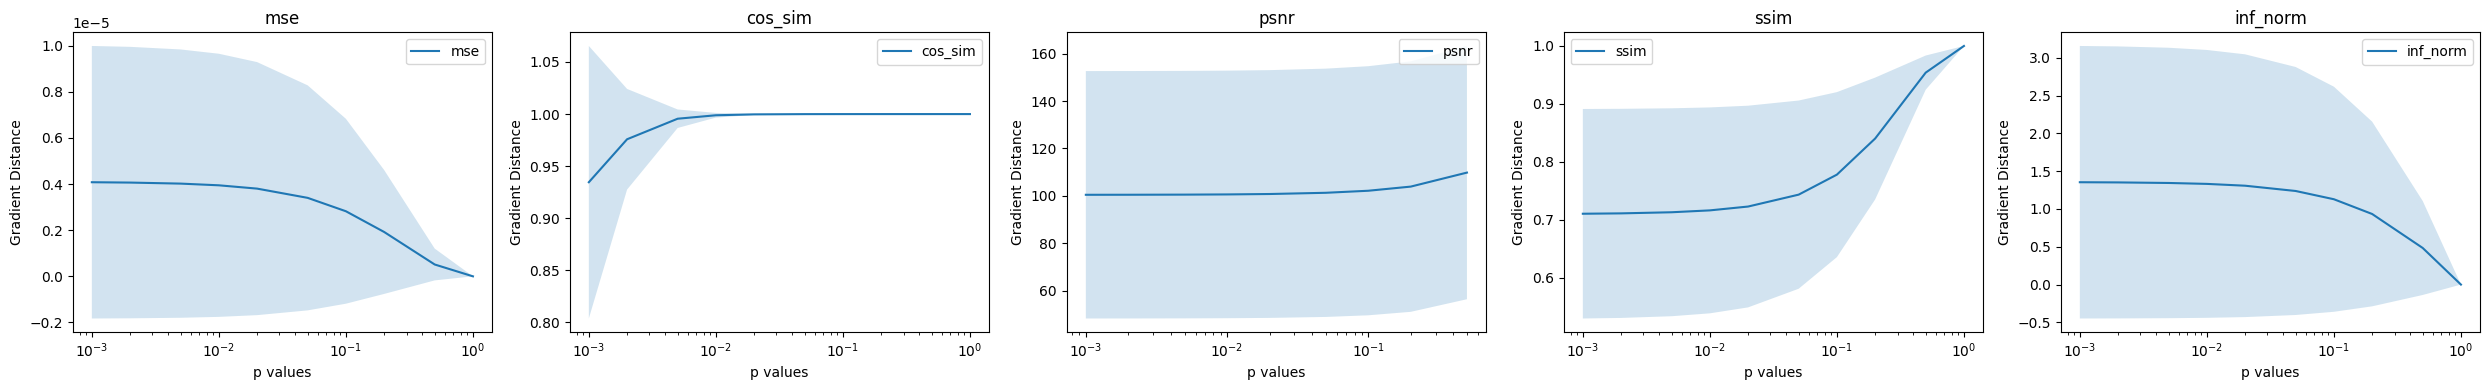

In [12]:
def compare_gradients(approx, ideal, metric_func):
    return metric_func(approx, ideal)


def get_grad_dist(metric_func):
    p_vals = p_values
    p_grad_dist = np.zeros_like(p_vals)
    p_grad_stds = np.zeros_like(p_vals)
    run_num = 0
    num_tasks = 5
    grad_name = 'grad_layers.0.weight'

    for i, p in enumerate(p_vals):
        task_vals = np.zeros(num_tasks)
        for task in range(num_tasks):
            p_grad_dir = f'models/mnist_split/{p}/run_{run_num}/ideal_grad_task_{task}/{grad_name}.npy'
            p_grad_arr = np.load(p_grad_dir)

            ideal_grad_dir = f'models/mnist_split/1/train/task_{task}/{grad_name}.npy'
            ideal_grad_arr = np.load(ideal_grad_dir)

            task_vals[task] = compare_gradients(p_grad_arr, ideal_grad_arr, metric_func)

        p_grad_dist[i] = np.mean(task_vals)
        p_grad_stds[i] = np.std(task_vals)

    return p_grad_dist, p_grad_stds

def plot_grad_dist(metrics, p_vals):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist(metric_func)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(p_vals, grad_dists, label=metric_func.__name__)
        ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('p values')
        ax.set_xscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_grad_dist(metrics_list, p_values)



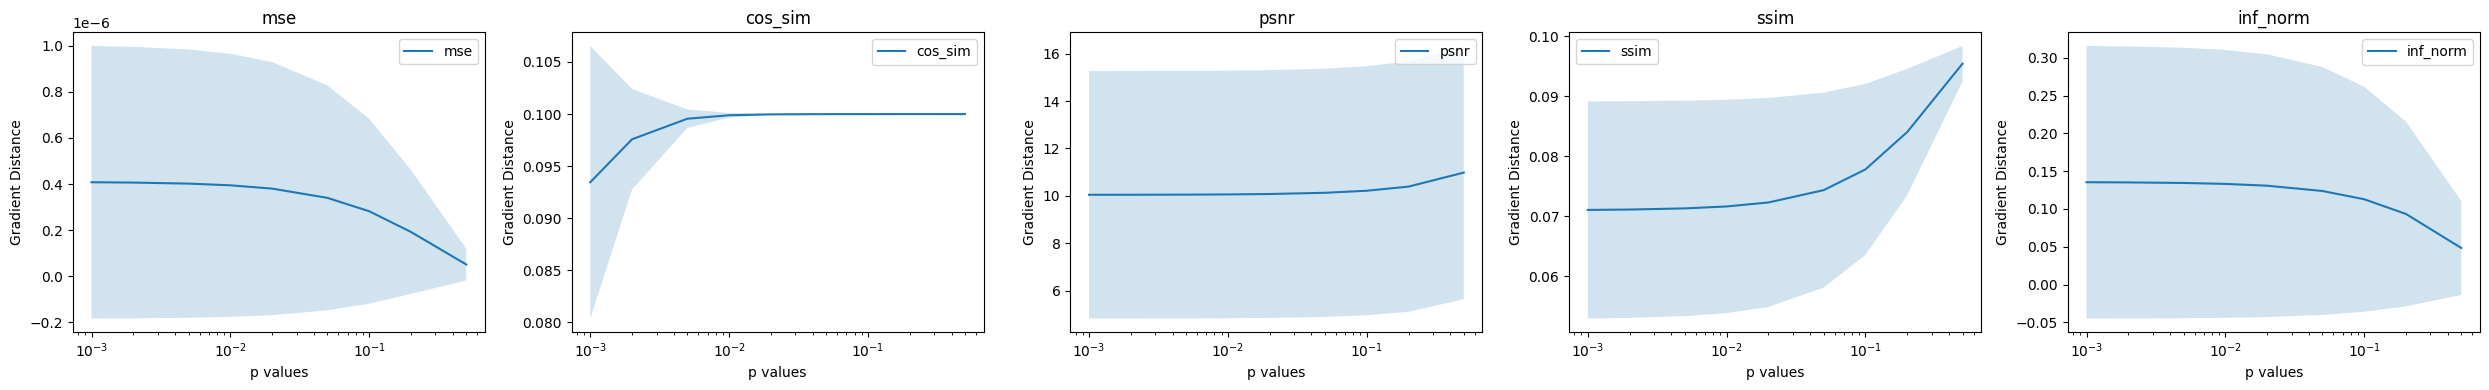

In [13]:
p_values2 = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

# testing version that averages over runs

def get_grad_dist(metric_func):
    p_vals = p_values2
    p_grad_dist = np.zeros_like(p_vals)
    p_grad_stds = np.zeros_like(p_vals)

    num_tasks = 5
    grad_name = 'grad_layers.0.weight'

    for i, p in enumerate(p_vals):
        task_vals = np.zeros(num_tasks)

        for run in range(10):
            p_grad_dist_runs = 0
            p_grad_std_runs = 0

            for task in range(num_tasks):
                p_grad_dir = f'models/mnist_split/{p}/run_{run}/ideal_grad_task_{task}/{grad_name}.npy'
                p_grad_arr = np.load(p_grad_dir)

                ideal_grad_dir = f'models/mnist_split/1/train/task_{task}/{grad_name}.npy'
                ideal_grad_arr = np.load(ideal_grad_dir)

                task_vals[task] = compare_gradients(p_grad_arr, ideal_grad_arr, metric_func)

            p_grad_dist_runs += np.mean(task_vals)
            p_grad_std_runs += np.std(task_vals)

        p_grad_dist_runs = p_grad_dist_runs/10
        p_grad_std_runs = p_grad_std_runs/10   

        p_grad_dist[i] = p_grad_dist_runs
        p_grad_stds[i] = p_grad_std_runs

    return p_grad_dist, p_grad_stds

def plot_grad_dist(metrics, p_vals):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist(metric_func)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(p_vals, grad_dists, label=metric_func.__name__)
        ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('p values')
        ax.set_xscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_grad_dist(metrics_list, p_values2)



### Metrics for CIFAR

In [14]:
import glob

def get_grad_dist_cifar(metric_func):
    p_vals = p_values
    p_grad_dist = np.zeros_like(p_vals)
    p_grad_stds = np.zeros_like(p_vals)
    run_num = 0
    num_tasks = 5

    for i, p in enumerate(p_vals):
        task_vals = np.zeros(num_tasks)
        for task in range(num_tasks):

            pattern_actual = f'models/cifar10_split/{p}/run_{run_num}/ideal_grad_task_{task}/grad_conv_block.*.weight.npy'
            pattern_ideal = f'models/cifar10_split/1/train/task_{task}/grad_conv_block.*.weight.npy'

            actual_weight_files = glob.glob(pattern_actual)
            ideal_weight_files = glob.glob(pattern_ideal)

            print(f"list of files: {actual_weight_files}")

            for i in range(len(actual_weight_files)):
                p_grad_actual_arr = np.load(actual_weight_files[i])
                p_grad_ideal_arr = np.load(ideal_weight_files[i])

                task_vals[task] = compare_gradients(p_grad_actual_arr, p_grad_ideal_arr, metric_func)
        
        p_grad_dist[i] = np.mean(task_vals)
        p_grad_stds[i] = np.std(task_vals)

    return p_grad_dist, p_grad_stds

    

def plot_grad_dist(metrics, p_vals):
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5*num_metrics, 4))  # Adjust subplot size as needed

    for idx, metric_func in enumerate(metrics):
        grad_dists, grad_stds = get_grad_dist_cifar(metric_func)
        if num_metrics > 1:  # Check if there are multiple metrics to avoid indexing error on axs
            ax = axs[idx]
        else:
            ax = axs  # Use axs directly if there's only one metric
        
        ax.plot(p_vals, grad_dists, label=metric_func.__name__)
        ax.fill_between(p_vals, grad_dists - grad_stds, grad_dists + grad_stds, alpha=0.2)

        ax.set_xlabel('p values')
        ax.set_xscale('log')
        ax.set_ylabel('Gradient Distance')
        ax.set_title(f'{metric_func.__name__}')
        ax.legend()

    plt.tight_layout()
    plt.show()


list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.6.weight.npy']
list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.6.weight.npy']
list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal

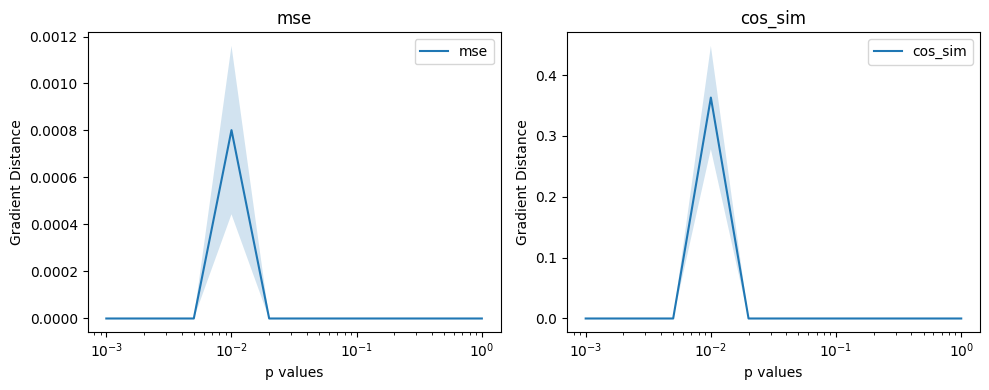

In [16]:
metrics_list = [mse, cos_sim]

plot_grad_dist(metrics_list, p_values)



Question: Why is glob.glob not finding the other convolutional blocks (like block 0, 6, or 8)??? 

#### something is wrong with the way the metrics are being computed: the PNSR, SSIM, and inf_norm metrics all have issues

list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_0/grad_conv_block.6.weight.npy']
list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_1/grad_conv_block.6.weight.npy']
list of files: ['models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.2.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.0.weight.npy', 'models/cifar10_split/0.001/run_0/ideal_grad_task_2/grad_conv_block.8.weight.npy', 'models/cifar10_split/0.001/run_0/ideal

ValueError: Improper number of dimensions to norm.

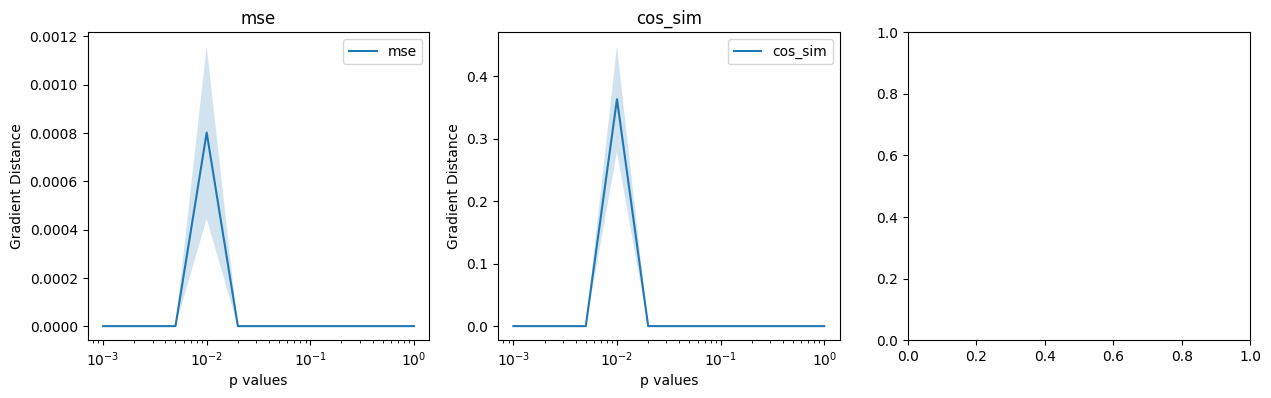

In [17]:
metrics_list = [mse, cos_sim, inf_norm]

plot_grad_dist(metrics_list, p_values)